# Car Pricing Model

## Summary

This is a basic pricing model algorithm using Generalized Linear Regression Model to predict selling price of Porsche 911 with Weissach_package and GT2 RS trim with the following features:

- *Year*
- *Mileage*
- *Number of previous owners*
- *Weissach Package*
- *GT2 RS Trim*
- *Transmission (Automatic vs. Manual)*
- *Accident (None vs. any accident)*

Once we determine the selling price of the vehicle, purchase price can be determined by applying the target margin % or  can be developed as a separate algorithm. 

_This model can be enhanced through ensembling various machine learning algorithms to capture other variables that influence the selling price, and apply to other car make/model with other features._

## Data Preparation

I created a dataset by filtering on the following conditions:
- *Make: Porsche*
- *Model: 911*

I also removed multiple listings of the same vehicles.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tabulate import tabulate
from scipy import stats

pd.set_option('float_format', '{:f}'.format)

In [2]:
df1 = pd.read_csv("data1.csv")
df2 = pd.read_csv("data2.csv")

In [111]:
model = "911"
trim = 'GT2 RS'

index1 = df1['Model'] == model
index2 = df2['Model'] == model
df1_ = df1[index1]
df2_ = df2[index2]

df = pd.concat([df1_, df2_])
df = df.dropna(subset=['PRICE_CURRENT'])
df = df.drop_duplicates('listing_id',keep='last')

df['Trim'] = df['Trim'].fillna("")
df['TrimTarget'] = np.where(df['Trim'].str.contains(trim)==True, 1, 0)
df['Trans_Auto'] = np.where(df['Transmission'].str.contains("Auto")==True, 1, 0)
df['Accidents_No'] = np.where(df['Accidents'].str.contains("No")==True, 1, 0)

df['TrimTarget'] = df['TrimTarget'].astype("category")
df['Trans_Auto'] = df['TrimTarget'].astype("category")
df['Weissach_package'] = df['Weissach_package'].astype("category")
df['Accidents_No'] = df['Accidents_No'].astype("category")

## Explanatory Data Analysis

### Summary Statistics

Below is the snippet of the dataset. Weissach Package is a categorical variable indicating whether the vehicle has Weissach Package or not. Similarly, Trim variable indicates whether it is GT2 RS Trim or not. Transmission Auto indicates Automatic or Manual transmission.

There is also a summar statistics table for each of the column in the dataset. It is interesting to note that the average selling price of Porsche 911 is $121,235.18, with average mileage of 17,415.76 and year of 2016.

In [82]:
print(df['PRICE_CURRENT'].describe()/1000)

count     11.163000
mean     121.507415
std       57.544802
min        0.000000
25%       83.987000
50%      113.949000
75%      144.494000
max     1587.756000
Name: PRICE_CURRENT, dtype: float64


In [112]:
df.head()

,id,listing_id,Year,Make,Model,Trim,Type,Dealer,Location,Mileage,...,PRICE_CURRENT,Title_check,Accidents,Owners,Additional_information,URL,Weissach_package,TrimTarget,Trans_Auto,Accidents_No
12,36687,278358729,2019,Porsche,911,Targa 4 GTS Cabriolet AWD,NaN,Porsche Grapevine,"Grapevine, TX",6393.000000,...,134900.000000,No issues reported,No issues reported,1.000000,"[!@@Additional Info@@!]Turbocharged,All Wheel ...",https://www.cargurus.com/Cars/inventorylisting...,0,0,0,1
26,36790,273473216,2017,Porsche,911,Carrera Coupe RWD,NaN,private seller,"Ada, MI",19800.000000,...,72000.000000,No issues reported,No issues reported,2.000000,"CPO Porsche 911 (991.2) Carrera, Manual, 19,80...",https://www.cargurus.com/Cars/inventorylisting...,0,0,0,1
30,36827,278592980,2018,Porsche,911,GT3 Coupe RWD,NaN,BMW of Fort Myers,"Fort Myers, FL",3930.000000,...,144999.000000,No issues reported,No issues reported,2.000000,"KBB.com Best Resale Value Awards. Only 3,930 M...",https://www.cargurus.com/Cars/inventorylisting...,0,0,0,1
37,36873,275904837,2018,Porsche,911,GT3 Coupe RWD,NaN,private seller,"Dallas, TX",4100.000000,...,146900.000000,No issues reported,No issues reported,3.000000,Low mileage Racing Yellow 911 GT3 for sale in ...,https://www.cargurus.com/Cars/inventorylisting...,0,0,0,1
115,37380,275203020,2014,Porsche,911,Turbo Coupe AWD,NaN,LUXE Automotive Sales,"Salt Lake City, UT",10579.000000,...,104995.000000,No issues reported,No issues reported,1.000000,2014 Porsche 911 Turbo LUXE Automotive Sales C...,https://www.cargurus.com/Cars/inventorylisting...,0,0,0,1


In [113]:
df.describe(include='all')
df['Accidents'].describe

<bound method NDFrame.describe of 12        No issues reported
26        No issues reported
30        No issues reported
37        No issues reported
115       No issues reported
                 ...        
723306    No issues reported
723307    No issues reported
723308    No issues reported
723309    No issues reported
723310    No issues reported
Name: Accidents, Length: 11163, dtype: object>

### Visualization

We delve further into the selling price. The below sharts show the density and spread of the selling price. 

We see the most of the prices are below \\$250,000. In the box-plot chart on the right, we see a few outliers where prices are above \\$1 million. 

I removed car selling prices above \\$750,000 as these outliers will introduce bias to the model and skew the results. The second set of charts are showing selling prices removing outliers.

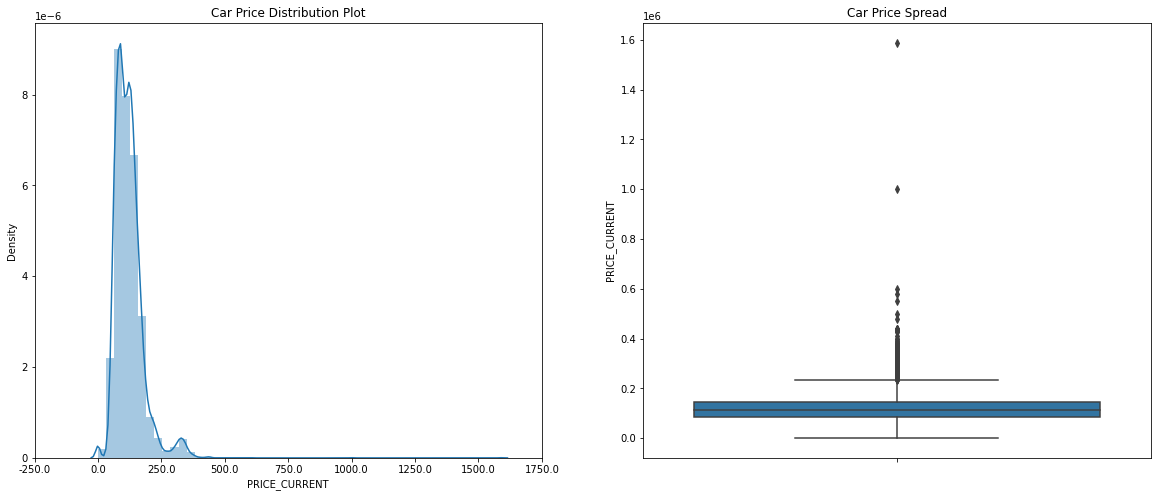

In [72]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
fig = sns.distplot(df['PRICE_CURRENT'])
plt.xticks(fig.get_xticks(),fig.get_xticks() / 1000)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
fig2 = sns.boxplot(y=df['PRICE_CURRENT'])


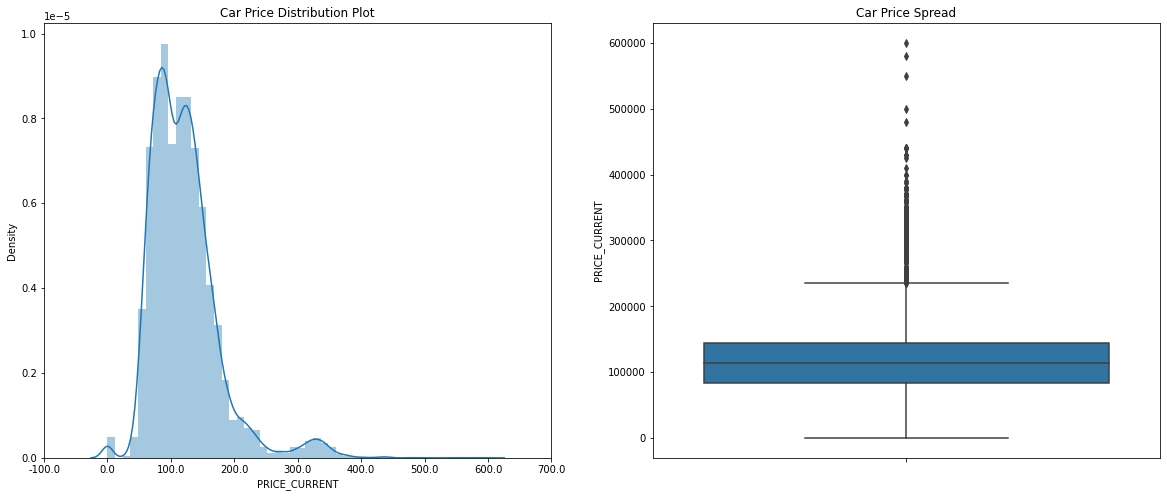

In [116]:
df_ = df[df['PRICE_CURRENT'] <= 750000]

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
fig = sns.distplot(df_['PRICE_CURRENT'])
plt.xticks(fig.get_xticks(),fig.get_xticks() / 1000)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
fig2 = sns.boxplot(y=df_['PRICE_CURRENT'])


# Model

I used Generalized Linear Model to predict the selling price of Porsche 911. It is slightly different from linear regression as it does not have a base intercept and all the predicting effects are attributed to all the variables. I chose this regression method as this is more flexible to work with varying features of the dataset that may have non-linear relationships with y.

Looking at the coefficients, we can quantify the incremental values of the variables on the selling price.


### Coefficients

- **Year**: Increasing 1 year is equivalent to +72.7 in selling price

- **Mileage**: Increasing 1 mile is equivalent to -1.53 in selling price

- **Owners**: Having 1 more owner is equivalent to -1,762 in selling price

- **Weissach Package**: Having this package is equivalent to +46,140 in selling price

- **Trim**: Being GT2 RS trim is equivalent to +94,630 in selling price

- **Transmission**: Auto transmission is equivalent to +94,630 than Manual transmission in selling price

- **Accident**: No accident is equivalent to +6,694 than having any accident in selling price

In [117]:
df_m = df_[['PRICE_CURRENT','Year','Mileage','Owners','Weissach_package','TrimTarget','Trans_Auto','Accidents_No']]
df_m = df_m.dropna()
X = df_m[['Year','Mileage','Owners','Weissach_package','TrimTarget','Trans_Auto','Accidents_No']]
y = df_m['PRICE_CURRENT']
model = sm.GLM(y,X, family=sm.families.Gaussian())
out = model.fit()
y_pred=out.predict()
print(out.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          PRICE_CURRENT   No. Observations:                 9731
Model:                            GLM   Df Residuals:                     9725
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                      1.3875e+09
Method:                          IRLS   Log-Likelihood:            -1.1623e+05
Date:                Mon, 26 Apr 2021   Deviance:                   1.3493e+13
Time:                        03:21:40   Pearson chi2:                 1.35e+13
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Year                69.3704      0.861  

### Performance

I plotted actual vs. predicted selling price. We see that most of the variance are normally distributed with difference beinng dense around 0. The line graph also shows the same variance, almost straight line at zero, except for extreme cases.

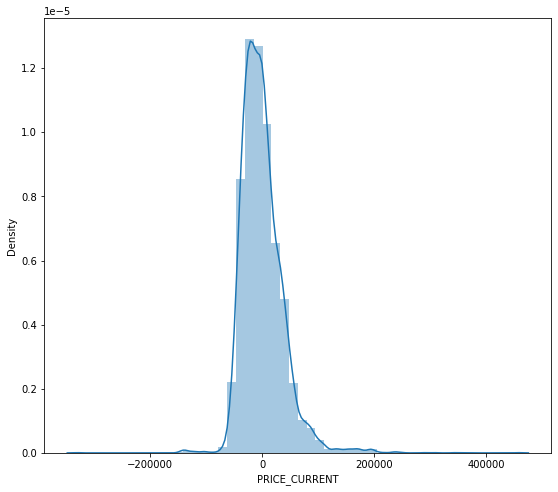

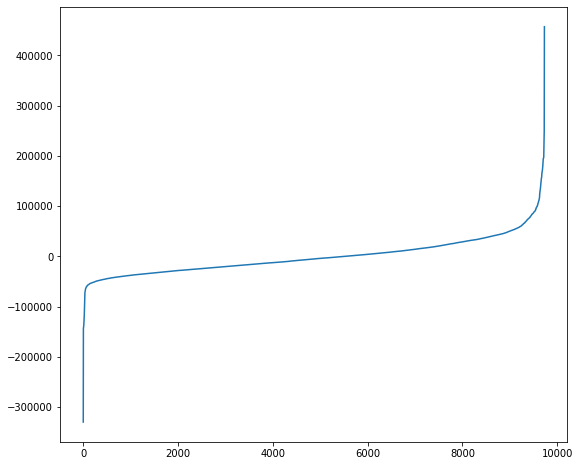

In [118]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

sns.distplot(y - y_pred)
plt.show()

plt.figure(figsize=(20,8))
plt.subplot(1,2,2)
plt.plot(sorted(y-y_pred))
plt.show()



### Prediction

Now that we have the model, we predict the selling price of Porsche 911 GT2 RS with Weissach Package. We also need to specify Year / Mileage / Number of owners to get the predicted selling price. 

I chose Year 2019, Mileage 10,000 and 1 owner, Automatic transmission, and no accident.

The tables below the code are showing the following - given Year, Number of Owners, it searches the listings from the data that matches the criteria closely. The only thing that I cannot do exact match on is the mileage. Therefore, it shows the 1 listing that has the least amount of variance to the mileage specified.

- First table shows the 1 listing record that has the least amount of variance to the mileage specified
- Second table shows a number of listings that match Year and Owner criteria

The predicted selling price is compared to the selling price of the vehicle from 1 listing from the first table, as well as the average of the listings from the second table.

### Results


| Name            |   Price $ |   Delta |
|-----------------|-----------|---------|
| Predicted Price |    365332 |     0   |
| 1 listing Price |    329800 | 35532.4 |
| Avg. Price      |    333511 | 31821.4 |

In [128]:
Year = 2019
Mileage = 10000
Owners = 1
Weissach_package = 1
TrimTarget = 1
Trans_Auto = 1
No_Accidents = 1

X_test = pd.DataFrame(columns = ['Year','Mileage','Owners','Weissach_package','TrimTarget','Trans_Auto','Accidents_No'])
X_test.loc[0] = [Year,Mileage,Owners,Weissach_package,TrimTarget,Trans_Auto,No_Accidents]
price_pred = out.predict(exog=X_test)

df_sub = df.loc[(df['Year']==Year) & (df['Owners'] ==Owners) & (df['Weissach_package']==Weissach_package) & (df['TrimTarget'] == TrimTarget) & (df['Trans_Auto'] == Trans_Auto)]
df_sub['Mileage_Delta'] = abs(df_sub['Mileage'] - Mileage)
match = df_sub['Mileage_Delta']==min(df_sub['Mileage_Delta'])

price_mean = np.mean(df_sub['PRICE_CURRENT'])
price_one = df_sub['PRICE_CURRENT'][match]

d1 = price_pred[0] - price_one
d2 = price_pred[0] - price_mean

headers = ['Name','Price $', 'Delta']
table = [["Predicted Price", price_pred[0], 0], ["1 listing Price", price_one, d1], ["Avg. Price", price_mean, d2]]

print(tabulate(table,headers=headers, tablefmt="github"))

display(df_sub[match])
display(df_sub)


| Name            |   Price $ |   Delta |
|-----------------|-----------|---------|
| Predicted Price |    365332 |     0   |
| 1 listing Price |    329800 | 35532.4 |
| Avg. Price      |    333511 | 31821.4 |


,id,listing_id,Year,Make,Model,Trim,Type,Dealer,Location,Mileage,...,Title_check,Accidents,Owners,Additional_information,URL,Weissach_package,TrimTarget,Trans_Auto,Accidents_No,Mileage_Delta
69240,6330,289152154,2019,Porsche,911,GT2 RS Coupe RWD,NaN,Formula Sports Cars,"Miami, FL",5270.000000,...,No issues reported,No issues reported,1.000000,Prod Month: 2018-12-15VIN: *WP0AE2A99KS155149*...,https://www.cargurus.com/Cars/inventorylisting...,1,1,1,1,4730.000000


,id,listing_id,Year,Make,Model,Trim,Type,Dealer,Location,Mileage,...,Title_check,Accidents,Owners,Additional_information,URL,Weissach_package,TrimTarget,Trans_Auto,Accidents_No,Mileage_Delta
595187,3463,274036980,2019,Porsche,911,GT2 RS Coupe RWD,NaN,Porsche of Kings Auto Mall,"Cincinnati, OH",1644.000000,...,No issues reported,No issues reported,1.000000,[!@@Additional Info@@!]DASHBOARD TRIM PACKAGE ...,https://www.cargurus.com/Cars/inventorylisting...,1,1,1,1,8356.000000
614466,10873,271237507,2019,Porsche,911,GT2 RS Coupe RWD,NaN,Ferrari-Maserati of New England,"Norwood, MA",177.000000,...,No issues reported,No issues reported,1.000000,This 2019 Porsche 911 GT2 RS Coupe has intoxic...,https://www.cargurus.com/Cars/inventorylisting...,1,1,1,1,9823.000000
807084,10165,277720384,2019,Porsche,911,GT2 RS Coupe RWD,NaN,MotorCar Gallery Inc,"Fort Lauderdale, FL",488.000000,...,No issues reported,No issues reported,1.000000,"Our GT2 RS boasts a $333,990 sticker price. Th...",https://www.cargurus.com/Cars/inventorylisting...,1,1,1,1,9512.000000
69240,6330,289152154,2019,Porsche,911,GT2 RS Coupe RWD,NaN,Formula Sports Cars,"Miami, FL",5270.000000,...,No issues reported,No issues reported,1.000000,Prod Month: 2018-12-15VIN: *WP0AE2A99KS155149*...,https://www.cargurus.com/Cars/inventorylisting...,1,1,1,1,4730.000000
172110,5176,290103719,2019,Porsche,911,GT2 RS Coupe RWD,NaN,McLaren Palm Beach,"West Palm Beach, FL",2985.000000,...,No issues reported,No issues reported,1.000000,This 2019 Porsche 911 GT2 RS is featured in Wh...,https://www.cargurus.com/Cars/inventorylisting...,1,1,1,1,7015.000000
172491,7703,271879512,2019,Porsche,911,GT2 RS Coupe RWD,NaN,Ferrari Maserati of Central Florida,"Orlando, FL",265.000000,...,No issues reported,No issues reported,1.000000,Chalk 2019 Porsche 911 GT2 RS RWD 7-Speed Pors...,https://www.cargurus.com/Cars/inventorylisting...,1,1,1,1,9735.000000
447171,4655,283418377,2019,Porsche,911,GT2 RS Coupe RWD,NaN,Porsche Wichita,"Wichita, KS",747.000000,...,No issues reported,No issues reported,1.000000,Porsche of Wichita is pleased to add to our li...,https://www.cargurus.com/Cars/inventorylisting...,1,1,1,1,9253.000000
